In [1]:
!pip install pennylane

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 47.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.3/934.3 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.9/167.9 kB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 56.9 MB/s eta 0:00:00


In [2]:
# import pennylane as qml
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm
import sys

# Setting our constants
sys.path.append('..')

In [3]:
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
!wget https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy

--2026-01-03 14:27:44--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_X.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 32896 (32K) [application/octet-stream]
Saving to: ‘train_X.npy’

train_X.npy         100%[===================>]  32.12K  --.-KB/s    in 0.003s  

2026-01-03 14:27:44 (10.5 MB/s) - ‘train_X.npy’ saved [32896/32896]

--2026-01-03 14:27:44--  https://raw.githubusercontent.com/aifactory-team/AFCompetition/main/9245/train_y.npy
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 256 [

In [4]:
train_X = np.load("train_X.npy")
train_y = np.load("train_y.npy")

In [ ]:
print(train_X.shape)
print(train_y)



(16, 256)
[0 0 0 0 1 1 1 1 2 2 2 2 3 3 3 3]


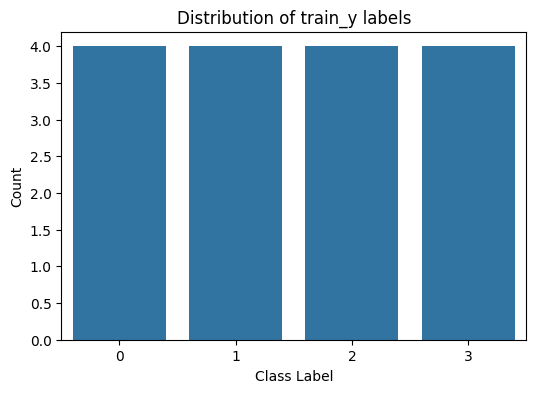

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the distribution of train_y
plt.figure(figsize=(6, 4))
sns.countplot(x=train_y)
plt.title('Distribution of train_y labels')
plt.xlabel('Class Label')
plt.ylabel('Count')
plt.show()

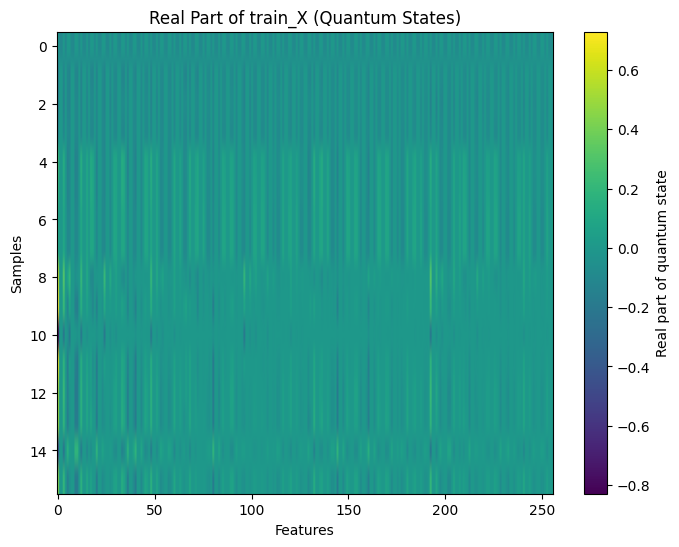

In [ ]:
# Plot the real part of train_X as an image
plt.figure(figsize=(8, 6))
plt.imshow(np.real(train_X), cmap='viridis', aspect='auto')
plt.colorbar(label='Real part of quantum state')
plt.title('Real Part of train_X (Quantum States)')
plt.xlabel('Features')
plt.ylabel('Samples')
plt.show()

In [5]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

# ==========================================
# 1. Inference (Model Prediction) - 기존 유지
# ==========================================
def get_predictions(model, inputs):
    """Run inference on inputs using the trained model."""
    model.eval()
    with torch.no_grad():
        outputs = model(inputs)
        predicted_labels = torch.argmax(outputs, dim=1)
    return predicted_labels.cpu().numpy()

def data_to_tensor(X, y):
    tensor_X = torch.tensor(X, dtype=torch.complex64)
    tensor_y = torch.tensor(y, dtype=torch.long)
    return tensor_X, tensor_y

t_train_X, t_train_y = data_to_tensor(train_X, train_y)
train_dataset = TensorDataset(t_train_X, t_train_y)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:209: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from pennylane import numpy as np
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)
device = "cuda" if torch.cuda.is_available() else "cpu"

def Quantum_classifier(params):
    wires = [i for i in range(n_qubits)]
    params = params.reshape(-1,3,8)
    for layer in range(params.shape[0]-1):
        for i, wire in enumerate(wires):
            qml.Rot(params[layer,0,i], params[layer,1,i], params[layer,2,i], wires=wire)
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
    for i, wire in enumerate(wires):
        qml.Rot(params[-1,0,i], params[-1,1,i], params[-1,2,i], wires=wire)



@qml.qnode(dev, interface='torch')
def linear_2qubit_block(state, params):
    wires = [i for i in range(n_qubits)]
    qml.StatePrep(state, wires=wires)
    Quantum_classifier(params)

    return qml.probs(wires=[6,7])
class QNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.total_params = 5*3*8  # 15 layers, 3 params per qubit, 8 qubits
        torch.manual_seed(42)
        self.params = nn.Parameter(torch.randn(self.total_params, requires_grad=True)*0.01)

    def forward(self, x):
        preds = linear_2qubit_block(x, self.params)
        return preds

model = QNN()
model.to(device=device)
optimizer = optim.Adam(model.parameters(), lr=0.05)


epochs = 100
loss_history = []
acc_history = []
print(f"--- Training QNN (Params: {model.total_params}) ---")

def quantum_phase_loss(probs, labels):
    """
    Custom Loss Function based on Eq. (10) of the paper.
    Loss = 1 - (Probability of the correct class)
    """
    # probs shape: (batch_size, 4)
    # labels shape: (batch_size,)


    batch_size = probs.shape[0]

    # 정답 인덱스의 확률 추출 (Advanced Indexing)
    label_one_hot = torch.nn.functional.one_hot(labels, num_classes=probs.shape[1])
    probs = probs
    probs = probs / torch.sum(probs, dim=1, keepdim=True)

    loss = -torch.sum(label_one_hot*torch.log(probs), dim=1)

    # 배치 평균 반환
    return torch.mean(loss)


for epoch in range(epochs):
    total_loss = 0
    correct = 0

    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        predictions = model(batch_X.to(device=device))
        loss = quantum_phase_loss(predictions, batch_y.to(device=device))
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        predicted_classes = torch.argmax(predictions, dim=1)
        batch_y = batch_y.to(predicted_classes.device)
        correct += (predicted_classes == batch_y).sum().item()

    avg_loss = total_loss / len(train_loader)
    avg_acc = correct / len(train_dataset)
    loss_history.append(avg_loss)
    acc_history.append(avg_acc)
    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

--- Training QNN (Params: 120) ---


In [ ]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# 1. 환경 설정
n_qubits = 8
n_layers = 3
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. 양자 회로 설계
def Quantum_block(params):
    # params shape: (n_layers, 3, n_qubits)
    for layer in range(params.shape[0]):
        # Rotation Layer
        for i in range(n_qubits):
            qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)

        # Entangling Layer (Ring topology)
        if layer < params.shape[0] - 1:
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    # inputs: (256,) 형태의 정규화된 데이터
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 마지막 2개 큐비트의 확률 측정 -> 2^2 = 4 클래스
    return qml.probs(wires=[6, 7])
    # return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# 3. 모델 클래스
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 가중치를 (layers, 3, n_qubits) 형태로 직접 선언
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)
        self.post_process = nn.Linear(n_qubits, 4)

    def forward(self, x):
        # batch 데이터를 qnode에 적용 (vmap 또는 반복문 처리)
        # PennyLane-Torch 인터페이스는 batch 입력을 지원합니다.
        return qnode(x, self.params)
        # q_out = qnode(x, self.params)
        # q_out = torch.stack(q_out, dim=1).float() # (batch_size, 8)

        # logits = self.post_process(q_out)
        # return logits

# 4. 데이터 준비 (예시)
# train_x: (16, 256), train_y: (16,)
train_x = torch.randn(16, 256)
# !! 중요 !! Amplitude Embedding을 위한 정규화
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True)
train_y = torch.tensor([0, 1, 2, 3] * 4) # 예시 레이블

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 5. 학습 설정
model = QNN(n_layers).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss() # 수치적으로 안정적인 Loss

# # 6. 학습 루프
# epochs = 100
# for epoch in range(epochs):
#     avg_loss = 0
#     correct = 0
#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)

#         optimizer.zero_grad()
#         # forward 시 qml.probs 결과값은 (batch, 4)
#         predictions = model(batch_X)

#         # log_softmax를 취해주는 것이 CrossEntropyLoss 사용 시 좋습니다.
#         # qml.probs는 확률이므로 log를 직접 취하거나 모델 끝에 epsilon을 더해줌
#         loss = criterion(torch.log(predictions + 1e-10), batch_y)

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() / len(train_loader)
#         predicted_classes = torch.argmax(predictions, dim=1)
#         correct += (predicted_classes == batch_y).sum().item()

#     avg_acc = correct / len(train_dataset)
#     if (epoch + 1) % 20 == 0:
#         print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {avg_acc:.4f}")

##SGD with momentum 적용

In [6]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block(params):
    for layer in range(params.shape[0]):
        # Rotation Layer
        for i in range(n_qubits):
            # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # if layer % 2 == 1: # 징검다리 얽힘 추가
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 2) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
# criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
criterion = nn.CrossEntropyLoss()

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: 1.0927 | Train Acc: 1.0000
Epoch 40 | Loss: 1.0302 | Train Acc: 1.0000
Epoch 60 | Loss: 0.9998 | Train Acc: 1.0000
Epoch 80 | Loss: 0.9903 | Train Acc: 1.0000
Epoch 100 | Loss: 0.9894 | Train Acc: 1.0000
Epoch 120 | Loss: 0.9875 | Train Acc: 1.0000
Epoch 140 | Loss: 0.9876 | Train Acc: 1.0000
Epoch 160 | Loss: 0.9829 | Train Acc: 1.0000
Epoch 180 | Loss: 0.9839 | Train Acc: 1.0000
Epoch 200 | Loss: 0.9842 | Train Acc: 1.0000
Epoch 220 | Loss: 0.9828 | Train Acc: 1.0000
Epoch 240 | Loss: 0.9817 | Train Acc: 1.0000
Epoch 260 | Loss: 0.9803 | Train Acc: 1.0000
Epoch 280 | Loss: 0.9789 | Train Acc: 1.0000
Epoch 300 | Loss: 0.9788 | Train Acc: 1.0000


#circuit 변경

In [19]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def Quantum_block2(params):
    for layer in range(params.shape[0]):
        # Rotation Layer
        if layer % 3 == 0:
            for i in range(n_qubits):
                qml.RX(params[layer, 0, i], wires=i)
        if layer % 3 == 1:
            for i in range(n_qubits):
                qml.RY(params[layer, 1, i], wires=i)
        if layer % 3 == 2:
            for i in range(n_qubits):
                qml.RZ(params[layer, 2, i], wires=i)
        # for i in range(n_qubits):
        #     # qml.Rot(params[layer, 0, i], params[layer, 1, i], params[layer, 2, i], wires=i)
        #     qml.RY(params[layer, 1, i], wires=i)
        #     qml.RZ(params[layer, 2, i], wires=i)

        # Entangling Layer (강력한 얽힘을 위해 Ring + Skip 구조 사용)
        # for i in range(n_qubits):
        #     qml.CNOT(wires=[i, (i + 1) % n_qubits])
        # if layer % 2 == 1: # 징검다리 얽힘 추가
        #     for i in range(n_qubits):
        #         qml.CNOT(wires=[i, (i + 2) % n_qubits])
        if layer % 2 == 0:
            # 짝수 레이어: 순방향 (0->1, 1->2 ...)
            for i in range(n_qubits):
                qml.CNOT(wires=[i, (i + 1) % n_qubits])
        else:
            # 홀수 레이어: 역방향 (7->6, 6->5 ...)
            for i in range(n_qubits - 1, -1, -1):
                qml.CNOT(wires=[i, (i - 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block2(params)
    # 제약 조건: 2개 큐비트의 확률 측정 (4개 클래스)
    return qml.probs(wires=[6, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        # 오직 양자 회로의 가중치만 가집니다.
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

    def forward(self, x):
        # qnode가 직접 (batch_size, 4) 형태의 확률을 반환합니다.
        probs = qnode(x, self.params)
        return probs

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.
# criterion = nn.CrossEntropyLoss()

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: 1.2332 | Train Acc: 0.8125
Epoch 40 | Loss: 1.2011 | Train Acc: 0.8750
Epoch 60 | Loss: 1.1842 | Train Acc: 0.8125
Epoch 80 | Loss: 1.1714 | Train Acc: 0.8750
Epoch 100 | Loss: 1.1630 | Train Acc: 1.0000
Epoch 120 | Loss: 1.1600 | Train Acc: 1.0000
Epoch 140 | Loss: 1.1565 | Train Acc: 1.0000
Epoch 160 | Loss: 1.1543 | Train Acc: 1.0000
Epoch 180 | Loss: 1.1540 | Train Acc: 1.0000
Epoch 200 | Loss: 1.1525 | Train Acc: 1.0000
Epoch 220 | Loss: 1.1519 | Train Acc: 1.0000
Epoch 240 | Loss: 1.1502 | Train Acc: 1.0000
Epoch 260 | Loss: 1.1492 | Train Acc: 1.0000
Epoch 280 | Loss: 1.1486 | Train Acc: 1.0000
Epoch 300 | Loss: 1.1488 | Train Acc: 1.0000


(<Figure size 4000x900 with 1 Axes>, <Axes: >)

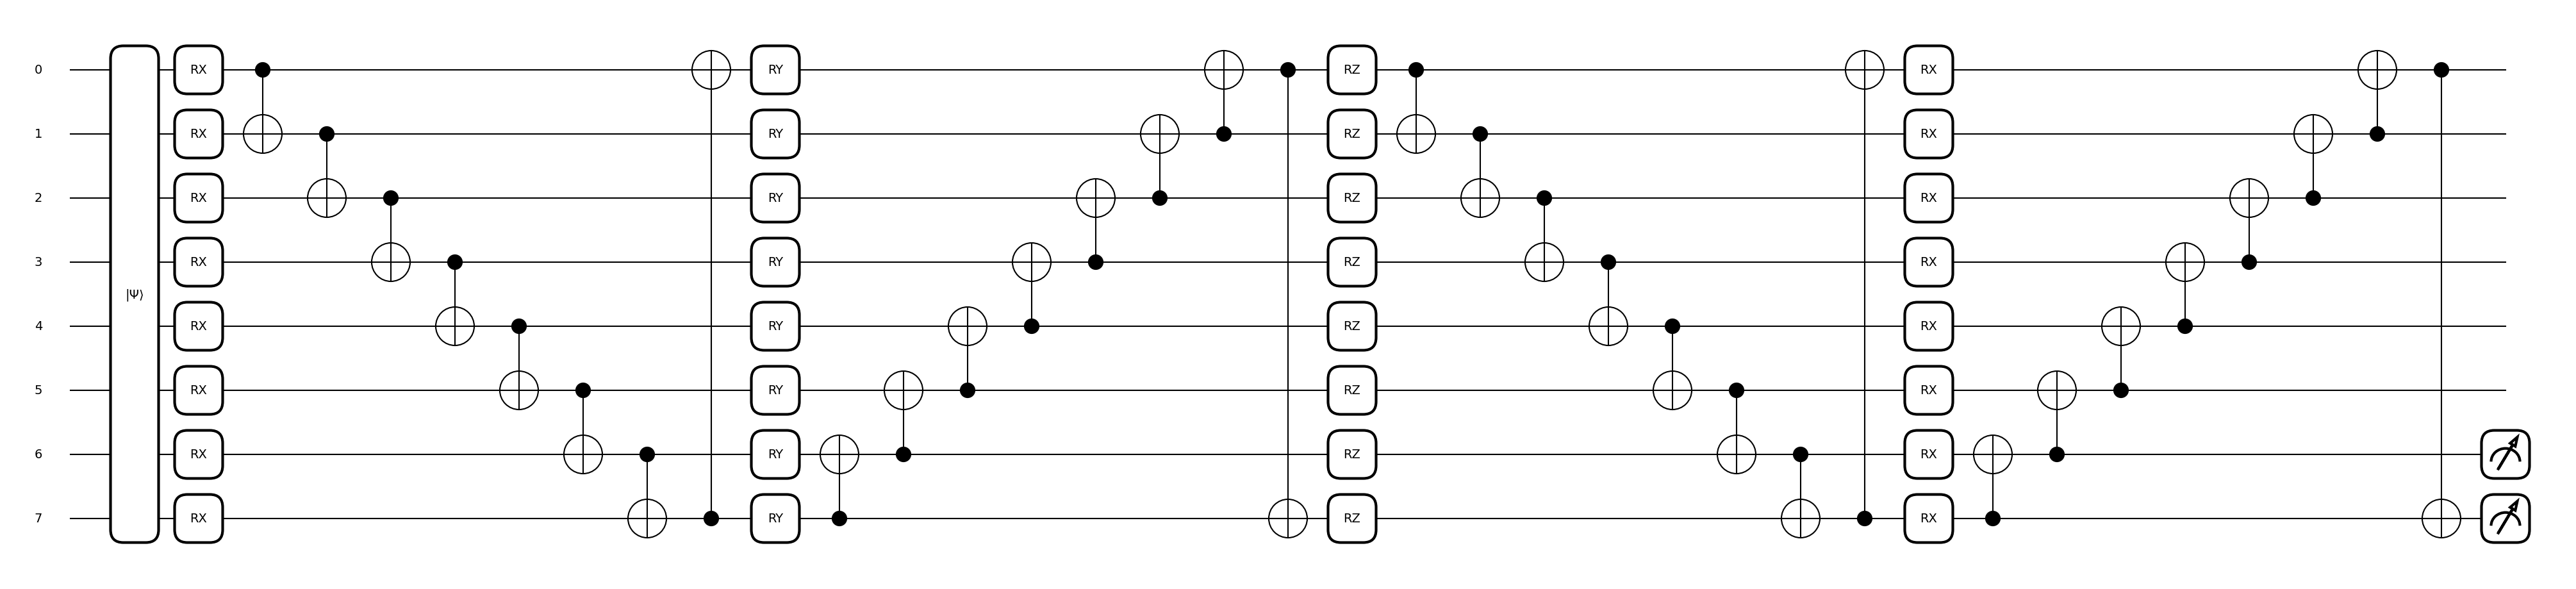

In [18]:
qml.draw_mpl(qnode)(batch_X,model.params)

Layer Norm 적용

In [45]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계 (기존과 동일)
def Quantum_block(params):
    for layer in range(params.shape[0]):
        for i in range(n_qubits):
            qml.RX(params[layer, 0, i], wires=i)
            qml.RY(params[layer, 1, i], wires=i)
            qml.RZ(params[layer, 2, i], wires=i)

        for i in range(n_qubits):
            qml.CNOT(wires=[i, (i + 1) % n_qubits])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(n_qubits))
    Quantum_block(params)
    return qml.probs(wires=[6, 7]) # 4개 클래스 확률 반환

# 2. 모델 클래스 (LayerNorm 추가)
class QNN(nn.Module):
    def __init__(self, n_layers):
        super().__init__()
        self.params = nn.Parameter(torch.randn(n_layers, 3, n_qubits) * 0.01)

        # Layer Normalization 추가: 입력 피처 크기는 qml.probs의 결과인 4
        # elementwise_affine=True로 설정하면 학습 가능한 gamma, beta가 포함됩니다.
        # self.ln = nn.LayerNorm(4)

    def forward(self, x):
        # 1. QNode 실행 (batch_size, 4)
        probs = qnode(x, self.params)

        eps = 1e-6
        mean = probs.mean(dim=-1, keepdim=True)
        var = probs.var(dim=-1, keepdim=True, unbiased=False)

        # 이 연산은 파라미터 업데이트가 없는 단순 '스케일링'입니다.
        normalized_out = (probs - mean) / torch.sqrt(var + eps)

        return probs

# 3. 데이터 준비 (기존과 동일)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True)
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QNN(n_layers).to(device)
# SGD with Momentum 유지
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# LayerNorm이 적용되면 출력값이 확률 범위를 벗어날 수 있으므로
# CrossEntropyLoss를 사용하는 것이 수치적으로 훨씬 안정적입니다.
criterion = nn.CrossEntropyLoss()

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()

        # 모델 출력 (정규화된 값)
        outputs = model(batch_X)

        # CrossEntropyLoss는 내부적으로 Softmax를 포함하므로
        # LayerNorm 이후의 값을 그대로 넣으면 됩니다.
        eps = 1e-6
        mu = outputs.mean(dim=-1, keepdim=True)
        std = outputs.std(dim=-1, keepdim=True)
        norm_out = (outputs - mu) / (std + eps)

        # 3. 정규화된 값으로 Loss 계산
        loss = criterion(outputs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(outputs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

# total_epochs = 300
# fine_tune_epochs = 250  # 마지막에 정규화 없이 학습할 에포크 수
# norm_stage_epochs = total_epochs - fine_tune_epochs

# # criterion = nn.NLLLoss() # 확률값에 log를 취해 전달하므로 NLLLoss 사용
# eps = 1e-6

# for epoch in range(total_epochs):
#     avg_loss = 0
#     is_fine_tuning = (epoch >= norm_stage_epochs) # Fine-tuning 단계 여부

#     for batch_X, batch_y in train_loader:
#         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
#         optimizer.zero_grad()

#         # 1. 양자 회로 실행 (Pure 확률값)
#         probs = model(batch_X)

#         if not is_fine_tuning:
#             # [단계 1: 정규화 학습] SGD Momentum이 길을 잘 잡도록 가이드
#             mean = probs.mean(dim=-1, keepdim=True)
#             std = probs.std(dim=-1, keepdim=True)
#             processed_out = (probs - mean) / (std + eps)

#             # 정규화된 출력에는 CrossEntropy가 수치적으로 더 안정적입니다.
#             loss = nn.functional.cross_entropy(processed_out, batch_y)
#         else:
#             # [단계 2: Fine-tuning] 정규화 없이 실전(QASM) 환경에 적응
#             # 0이 되어 log가 터지는 것을 방지하기 위해 eps 더함
#             log_probs = torch.log(probs + 1e-10)
#             loss = nn.functional.nll_loss(log_probs, batch_y)

#         loss.backward()
#         optimizer.step()
#         avg_loss += loss.item() / len(train_loader)

#     # 로그 출력
#     stage_name = "Fine-tuning" if is_fine_tuning else "Norm Training"
#     if (epoch + 1) % 10 == 0: #or is_fine_tuning:
#         print(f"Epoch [{epoch+1}/{total_epochs}] | Stage: {stage_name} | Loss: {avg_loss:.4f}")

## CNN 구현

In [51]:
import pennylane as qml
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

n_qubits = 8
n_layers = 4  # 고전 층이 없으므로 레이어를 약간 늘려 표현력을 보강합니다.
dev = qml.device("default.qubit", wires=n_qubits)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 양자 회로 설계
def conv_layer(wires, params):
    """인접한 큐비트들을 얽어 특징을 추출하는 층 (Convolution)"""
    for i in range(len(wires)):
        # qml.Rot(params[i, 0], params[i, 1], params[i, 2], wires=wires[i])
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i,1], wires=i)
        qml.RZ(params[i, 2], wires=i)
    for i in range(len(wires)):
        qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])

def pooling_layer(v_wires, s_wires, params):
    """정보를 s_wires로 압축하는 층 (Pooling)"""
    # v_wires: 버려질 큐비트들, s_wires: 살아남을 큐비트들
    for i in range(len(s_wires)):
        qml.CRot(params[i, 0], params[i, 1], params[i, 2], wires=[v_wires[i], s_wires[i]])
def Qcnn_block(params):
    # 각 유닛이 사용할 수 있게 모양을 재구성(Reshape)하거나 넉넉하게 할당합니다.
    # conv_layer는 최대 8개의 큐비트를 다루므로 (8, 3) = 24개가 필요
    # pooling_layer는 최대 4개의 쌍을 다루므로 (4, 3) = 12개가 필요
    # 총 36개의 파라미터가 필요합니다.
    conv_w = params[0:24].reshape(8, 3)
    pool_w = params[24:36].reshape(4, 3)

    wires = range(8)
    for i in range(len(wires)):
        qml.CNOT(wires=[wires[i], wires[(i + 1) % len(wires)]])
    # Layer 1: 8개 큐비트 전체 Convolution
    conv_layer(range(8), conv_w)

    # Layer 2: 8 -> 4 Pooling (0,2,4,6 -> 1,3,5,7)
    pooling_layer([0, 2, 4, 6], [1, 3, 5, 7], pool_w)

    # Layer 3: 남은 4개 Convolution (슬라이싱으로 4개만 사용)
    conv_layer([1, 3, 5, 7], conv_w[:4])

    # Layer 4: 4 -> 2 Pooling (1,5 -> 3,7)
    pooling_layer([1, 5], [3, 7], pool_w[:2])

@qml.qnode(dev, interface='torch')
def qnode(inputs, params):
    qml.StatePrep(inputs, wires=range(8))
    Qcnn_block(params)

    # 최종적으로 정보가 모인 3, 7번 큐비트의 확률 측정
    return qml.probs(wires=[3, 7])

# 2. 모델 클래스 (nn.Linear 제거)
class QCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # 모든 파라미터를 하나로 통합 (예: 13개)
        self.params = nn.Parameter(torch.randn(36) * 0.01)

    def forward(self, x):
        # 학습 시에는 StatePrep이 포함된 qnode 호출
        return qnode(x, self.params)

# 3. 데이터 준비 및 정규화 (매우 중요)
train_x = torch.randn(16, 256)
train_x = train_x / torch.norm(train_x, p=2, dim=1, keepdim=True) # L2 정규화
train_y = torch.tensor([0, 1, 2, 3] * 4).long()

dataset = TensorDataset(train_x, train_y)
train_loader = DataLoader(dataset, batch_size=4, shuffle=True)

# 4. 학습 설정
model = QCNN().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.01)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
criterion = nn.NLLLoss() # 확률값의 로그를 취하므로 NLLLoss가 적합합니다.

# 5. 학습 루프
epochs = 300
for epoch in range(epochs):
    avg_loss = 0
    correct = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        probs = model(batch_X)

        eps = 1e-6
        mu = probs.mean(dim=-1, keepdim=True)
        std = probs.std(dim=-1, keepdim=True)
        norm_out = (probs - mu) / (std + eps)

        # probs가 0이 되어 log가 -inf가 되는 것을 방지하기 위해 epsilon(1e-10)을 더함
        log_probs = torch.log(probs + 1e-10)
        loss = nn.functional.nll_loss(norm_out, batch_y)
        loss_raw = nn.functional.nll_loss(log_probs, batch_y)

        loss.backward()
        optimizer.step()

        avg_loss += loss.item() / len(train_loader)
        predicted_classes = torch.argmax(probs, dim=1)
        correct += (predicted_classes == batch_y).sum().item()

    if (epoch + 1) % 20 == 0:
        print(f"Epoch {epoch+1:02d} | Loss: {avg_loss:.4f} | Train Acc: {correct/len(train_x):.4f}")

Epoch 20 | Loss: -0.5886 | Train Acc: 0.6250
Epoch 40 | Loss: -1.0877 | Train Acc: 0.8125
Epoch 60 | Loss: -1.2782 | Train Acc: 1.0000
Epoch 80 | Loss: -1.4489 | Train Acc: 1.0000
Epoch 100 | Loss: -1.4721 | Train Acc: 1.0000
Epoch 120 | Loss: -1.4720 | Train Acc: 1.0000
Epoch 140 | Loss: -1.4678 | Train Acc: 1.0000
Epoch 160 | Loss: -1.4838 | Train Acc: 1.0000
Epoch 180 | Loss: -1.4585 | Train Acc: 1.0000
Epoch 200 | Loss: -1.4814 | Train Acc: 1.0000
Epoch 220 | Loss: -1.4906 | Train Acc: 1.0000
Epoch 240 | Loss: -1.4903 | Train Acc: 1.0000
Epoch 260 | Loss: -1.4455 | Train Acc: 1.0000
Epoch 280 | Loss: -1.4899 | Train Acc: 1.0000
Epoch 300 | Loss: -1.4819 | Train Acc: 1.0000


In [ ]:
# 8개의 큐비트 설정 (2^8 = 256 features)
n_qubits = 8
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(weights, features):
    # 1. Data Embedding: 256개의 특성을 8개 큐비트에 인코딩
    # features는 반드시 정규화(L2 norm = 1) 되어 있어야 합니다.
    qml.AmplitudeEmbedding(features=features, wires=range(n_qubits), normalize=True)

    # 2. Variational Layers: 학습 가능한 레이어
    # StronglyEntanglingLayers는 회전 게이트와 Entanglement를 반복하여 표현력을 높입니다.
    qml.StronglyEntanglingLayers(weights, wires=range(n_qubits))

    # 3. Measurement: 4개의 클래스 분류를 위해 4개 큐비트의 PauliZ 기대값 측정
    # 결과값은 [-1, 1] 사이의 값 4개가 반환됩니다.
    return [qml.expval(qml.PauliZ(i)) for i in range(2)]

# 가중치 초기화 (layers=3, qubits=8, parameters=3)
num_layers = 3
weight_shapes = {"weights": (num_layers, n_qubits, 3)}
weights = np.random.random(size=(num_layers, n_qubits, 3))

In [ ]:
print("Circuit Output:", quantum_circuit(weights, train_X))

NameError: name 'quantum_circuit' is not defined

(<Figure size 2400x900 with 1 Axes>, <Axes: >)

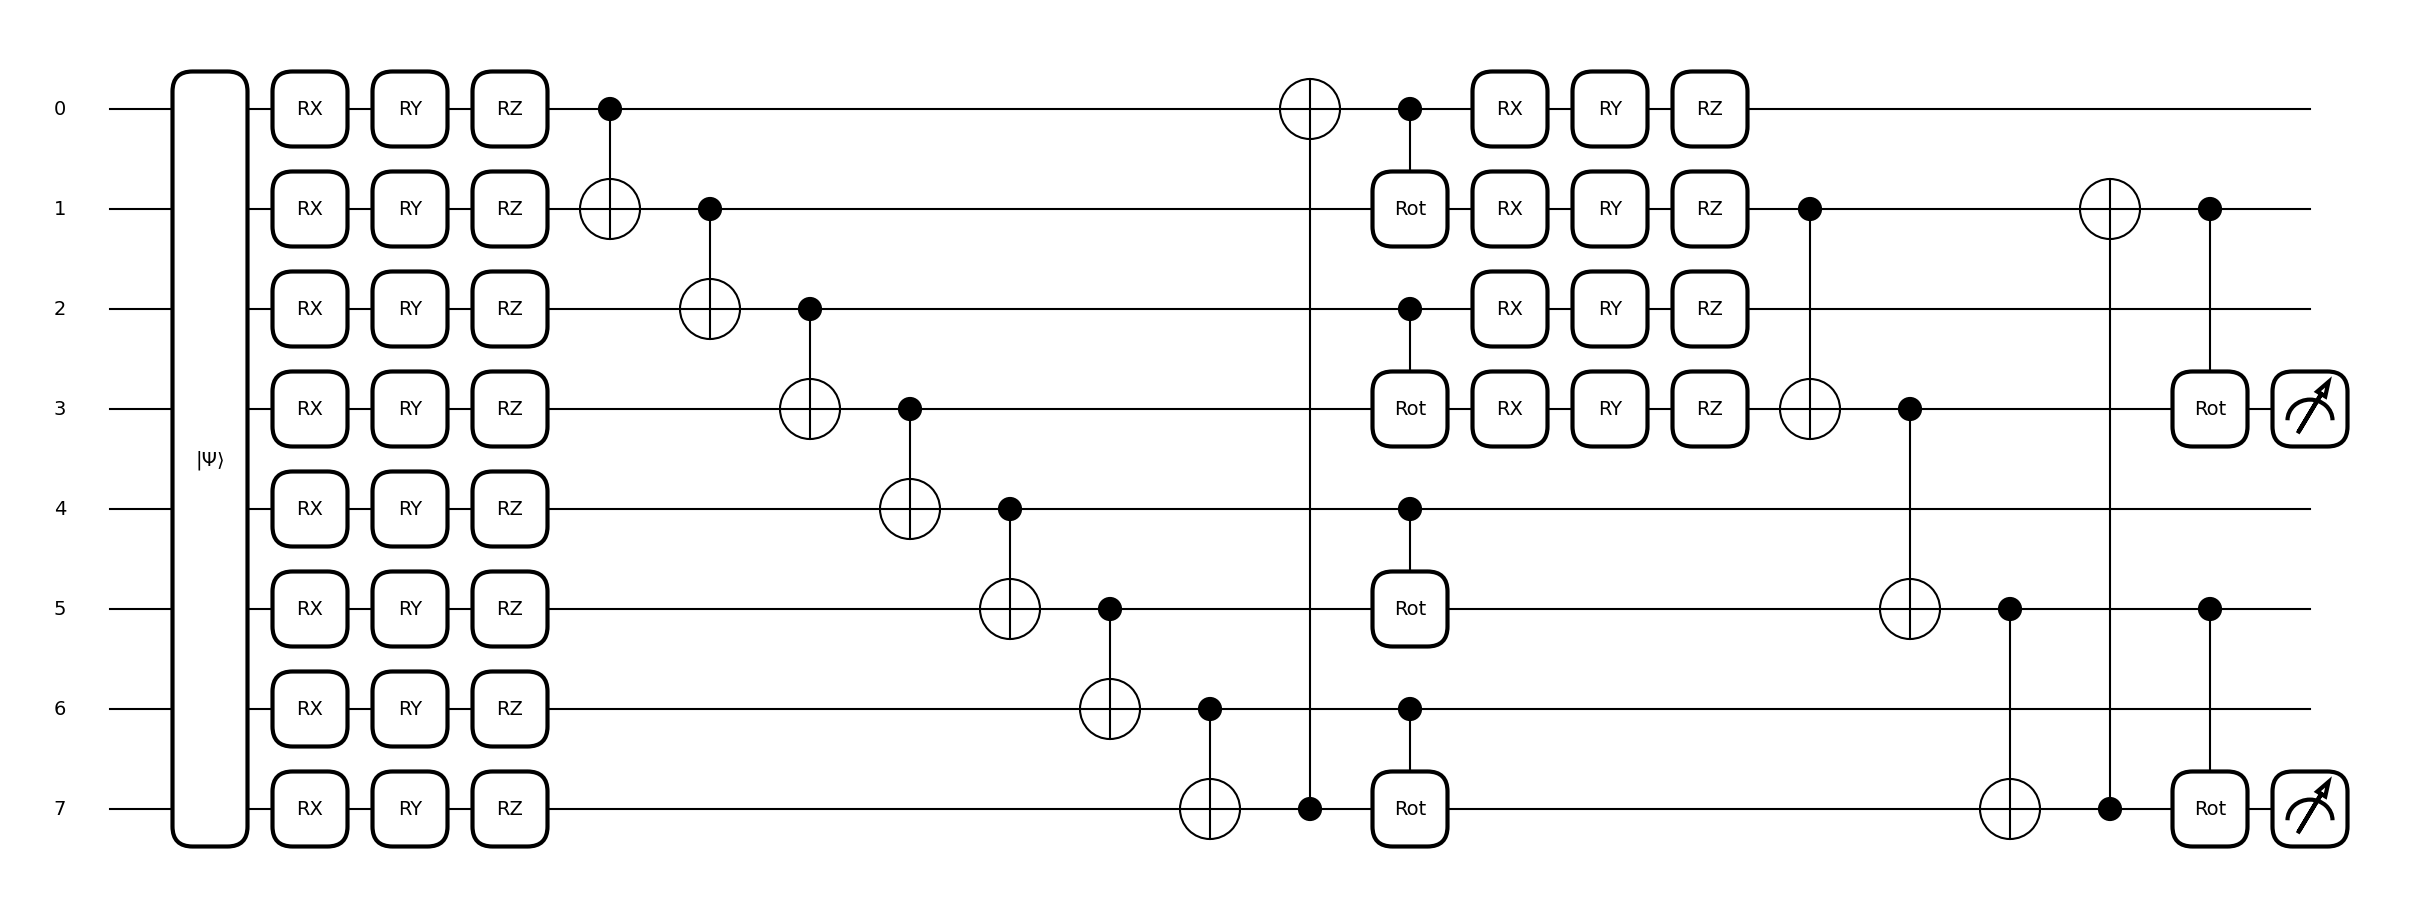

In [49]:
qml.draw_mpl(qnode)(batch_X,model.params)

모델 테스트

In [52]:
def validate_for_submission_with_loss(model, test_loader, device):
    model.eval()
    correct_raw = 0
    total_raw_loss = 0.0
    total_norm_loss = 0.0
    total = 0

    criterion = torch.nn.CrossEntropyLoss()
    eps = 1e-6

    print("\n" + "="*40)
    print("🔍 SUBMISSION VALIDATION REPORT")
    print("="*40)

    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)

            # 1. 모델 출력 (순수 확률값)
            probs = model(batch_X)

            # 2. Pure Loss (정규화 없이 계산)
            # 확률값이 0~1 사이이므로 log를 취해 계산하는 CrossEntropy 사용
            # (만약 CrossEntropy가 내부적으로 Softmax를 적용하는 게 싫다면
            #  직접 log(probs) + NLLLoss 조합을 써도 됩니다.)
            raw_loss = torch.nn.functional.cross_entropy(probs, batch_y)
            total_raw_loss += raw_loss.item()

            # 3. Normalized Loss (학습 시 사용했던 수식 적용)
            mean = probs.mean(dim=-1, keepdim=True)
            std = probs.std(dim=-1, keepdim=True)
            norm_probs = (probs - mean) / (std + eps)
            norm_loss = criterion(norm_probs, batch_y)
            total_norm_loss += norm_loss.item()

            # 4. Accuracy (정규화 없는 순수 상태 기준)
            pred_raw = torch.argmax(probs, dim=1)
            correct_raw += (pred_raw == batch_y).sum().item()
            total += batch_y.size(0)

    avg_raw_loss = total_raw_loss / len(test_loader)
    avg_norm_loss = total_norm_loss / len(test_loader)
    acc_raw = correct_raw / total

    print(f"📉 Avg Pure Loss (No Norm)  : {avg_raw_loss:.6f}")
    print(f"📉 Avg Norm Loss (Trainer)  : {avg_norm_loss:.6f}")
    print(f"🎯 Pure Accuracy (No Norm)  : {acc_raw*100:.2f}%")
    print("-" * 40)

    # 분석 가이드
    loss_gap = abs(avg_raw_loss - avg_norm_loss)
    if loss_gap > 1.0:
        print("⚠️ [의존성 경고] Norm 적용 여부에 따른 Loss 차이가 큽니다.")
        print("   제출 전 'Fine-tuning'을 통해 Pure Loss를 낮추는 것을 추천합니다.")
    elif acc_raw > 0.8:
        print("🚀 [최종 통과] 파라미터가 매우 안정적입니다. 지금 바로 QASM을 추출하세요!")
    else:
        print("💡 [팁] 정확도가 낮다면 에포크를 늘리거나 학습률을 조정해 보세요.")
    print("="*40 + "\n")

# 실행
validate_for_submission_with_loss(model, train_loader, device)


🔍 SUBMISSION VALIDATION REPORT
📉 Avg Pure Loss (No Norm)  : 1.357667
📉 Avg Norm Loss (Trainer)  : 0.348822
🎯 Pure Accuracy (No Norm)  : 100.00%
----------------------------------------
⚠️ [의존성 경고] Norm 적용 여부에 따른 Loss 차이가 큽니다.
   제출 전 'Fine-tuning'을 통해 Pure Loss를 낮추는 것을 추천합니다.



In [ ]:
import json

# 1. Specify measurement qubits
measurements = [6, 7]

# 2. Extract trained parameters
params = model.params.detach().cpu().numpy()

# 3. Define circuit for QASM conversion (Ansatz only, no StatePrep or Measurement)
@qml.qnode(dev, interface='torch')
def Classifier(params):
    Qcnn_block(params)
    return qml.probs(wires=[3, 7])

# 4. Generate OpenQASM string
qasm_data = qml.to_openqasm(Classifier, measure_all=False)(params)

print(f"✅ Measurement Qubits: {measurements}")
print(f"✅ QASM Data Generated (Length: {len(qasm_data)} characters)")
print("--- QASM Preview (First 10 lines) ---")
print("\n".join(qasm_data.split('\n')[:]))


with open("./baseline.json", "w") as f:
    json.dump({
        "qasm": qasm_data,
        "measurements": measurements
    }, f)
print("✅ Submission file 'baseline.json' created.")

✅ Measurement Qubits: [6, 7]
✅ QASM Data Generated (Length: 1826 characters)
--- QASM Preview (First 10 lines) ---
OPENQASM 2.0;
include "qelib1.inc";
qreg q[8];
creg c[8];
rz(0.27542356) q[0];
ry(-0.62671226) q[0];
rz(0.29706687) q[0];
rz(0.0819043) q[1];
ry(-0.6400486) q[1];
rz(-0.7674706) q[1];
rz(-0.79410225) q[2];
ry(-0.31427854) q[2];
rz(1.1333885) q[2];
rz(0.639912) q[3];
ry(0.6216696) q[3];
rz(-0.37909675) q[3];
rz(0.40983018) q[4];
ry(-0.6381937) q[4];
rz(0.27628696) q[4];
rz(-0.10322546) q[5];
ry(0.505227) q[5];
rz(-0.6556355) q[5];
rz(-0.2859867) q[6];
ry(1.2091591) q[6];
rz(-0.24854866) q[6];
rz(-0.4800581) q[7];
ry(1.3679211) q[7];
rz(-0.13193704) q[7];
cx q[0],q[1];
cx q[1],q[2];
cx q[2],q[3];
cx q[3],q[4];
cx q[4],q[5];
cx q[5],q[6];
cx q[6],q[7];
cx q[7],q[0];
rz(1.0979717) q[1];
cx q[0],q[1];
rz(0.80314314) q[1];
ry(-0.49977526) q[1];
cx q[0],q[1];
ry(0.49977526) q[1];
rz(-1.9011148) q[1];
rz(0.8391949) q[3];
cx q[2],q[3];
rz(-0.3567243) q[3];
ry(-0.68096817) q[3];
cx 

qreg q[8];
creg c[8];
rz(0.40498495) q[0];
ry(0.15300891) q[0];
rz(0.46771476) q[0];
rz(0.23690376) q[1];
ry(0.093031146) q[1];
rz(0.2598675) q[1];

In [ ]:
from google.colab import files
files.download('baseline.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>